<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/QuanNguyenDong/hateful-speech-classification/blob/main/AI-models/binary_classification_comment_dataset.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/QuanNguyenDong/hateful-speech-classification/blob/main/AI-models/binary_classification_comment_dataset.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

# Import dataset
First, the binary dataset that already being preprocessed is imported, with the labels are 1 for hateful comment and 0 for regular comment.

In [ ]:
path = "https://media.githubusercontent.com/media/QuanNguyenDong/hateful-speech-classification/main/dataset/binary_comment_dataset.csv"

dataset = pd.read_csv(path, encoding='utf8')

dataset.head()

,comment_text,hateful
0,was taken from britannica and columbia encyclo...,0
1,i think i got blocked for a bad reason as show...,1
2,go ahead make my day go ahead and block me ada...,1
3,request for arbitrationcoolkatt based on your ...,0
4,you are nothing more than a malignant cancer o...,1


Next, the data is splitted in to 3 part:

*   Training dataset: feed into model for training the behaviour (70% of whole data)
*   Validation dataset: use to validate the model whether it is fit, overfit or underfit (20%)
*   Testing dataset: use for test and evaluation of the model (10%)




In [ ]:
raw_train, raw_validation, raw_test = np.split(
    dataset.sample(frac=1),
    [int(0.7*len(dataset)), int(0.9*len(dataset))]
)

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

200652 training examples
57329 validation examples
28665 test examples


In [ ]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=512):
    df = dataframe.copy()
    labels = df.pop('hateful')
    df = df['comment_text'].astype(str)
    ds = tf.data.Dataset.from_tensor_slices((df, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    return ds

raw_train_ds = dataframe_to_dataset(raw_train)
raw_val_ds = dataframe_to_dataset(raw_validation)
raw_test_ds = dataframe_to_dataset(raw_test)

# Text Vectorization

The first layer of the model is **Text Vectorization** which converts the human string to number array. This is an preprocessing approach because neural network or even computer is not friendly with text but numeric data. There are some parameters that need to notice: **max_features** is vocabulary size of dataset (is restricted to 200,000), **sequence_length** defines the length of output (it will truncate the output to that length), the **output_mode='int'** cast the output array to an integer arr. Before using the layer, we adapt it with the train text so that the layer learns the vocabulary and dataset.

As the next step, we vectorize all of the dataset. The **vectorize_text** function will take 2 strings text and label, expanding the dimension of text tensor to match the expected input. In the last part, **cache(**) caches the dataset in memory to avoid bottlenecks and **prefetch** prefetches data for optimal performance, allowing for the automatic tuning of the buffer size.


In [ ]:
max_features = 200000
sequence_length = 300

def custom_standardization(input):
    lowercase = tf.strings.lower(input)
    return tf.strings.regex_replace(lowercase,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Neural Network model


In [ ]:
embedding_dim = 32

model = tf.keras.Sequential([
    layers.Input(shape=(sequence_length,)),
    layers.Embedding(
        input_dim=max_features,
        output_dim=embedding_dim
    ),
    layers.Dropout(0.2),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           6400000   
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

# Training

Now we'll train the model with 7 epochs. Notice that loss is descreasing and accuray is increasing over time.

In [ ]:
epochs = 7

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
392/392 [==============================] - 79s 195ms/step - loss: 0.3119 - binary_accuracy: 0.8637 - val_loss: 0.1364 - val_binary_accuracy: 0.9507
Epoch 2/7
392/392 [==============================] - 72s 183ms/step - loss: 0.1356 - binary_accuracy: 0.9496 - val_loss: 0.0889 - val_binary_accuracy: 0.9710
Epoch 3/7
392/392 [==============================] - 72s 182ms/step - loss: 0.0968 - binary_accuracy: 0.9650 - val_loss: 0.0710 - val_binary_accuracy: 0.9765
Epoch 4/7
392/392 [==============================] - 71s 181ms/step - loss: 0.0753 - binary_accuracy: 0.9731 - val_loss: 0.0621 - val_binary_accuracy: 0.9794
Epoch 5/7
392/392 [==============================] - 73s 187ms/step - loss: 0.0619 - binary_accuracy: 0.9781 - val_loss: 0.0584 - val_binary_accuracy: 0.9799
Epoch 6/7
392/392 [==============================] - 71s 182ms/step - loss: 0.0537 - binary_accuracy: 0.9814 - val_loss: 0.0549 - val_binary_accuracy: 0.9815
Epoch 7/7
392/392 [==============================] -

# Evaluation

We will evaluate the model with the test dataset. The number is not big different with training dataset indicating the model is not overfitting.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

56/56 [==============================] - 2s 25ms/step - loss: 0.0544 - binary_accuracy: 0.9811
Loss:  0.05439580976963043
Accuracy:  0.9810919165611267


The diagram below shows the training/ validation loss and accuracy over epochs helping us visualize the model's learning process and performance.

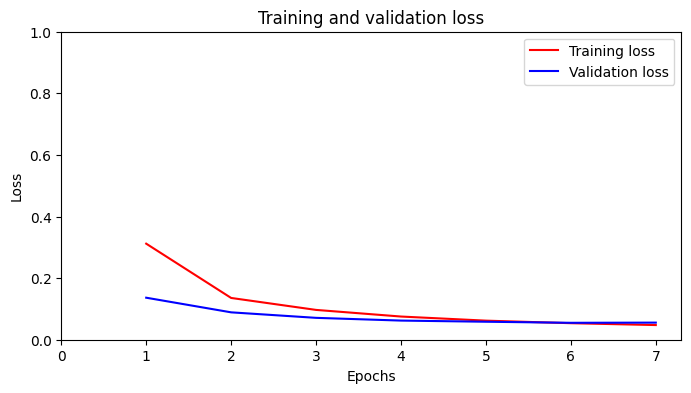

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

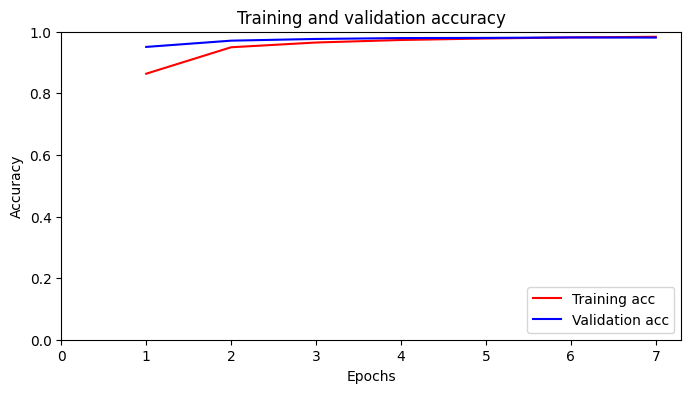

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

# Exporting the model

The model we defined above takes vectors as an input. To simplify deploying it and make the model capable of processing raw string, we include the **vectorize_layer** in the export model.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(loss=losses.BinaryCrossentropy(),
                      optimizer='adam',
                      metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Now we can pass the raw string to the CNN model. Let's get the model predicts some comments and see the results.

1/1 [==============================] - 0s 226ms/step
Wish you cut your veins. Don't shout out you have mental problem


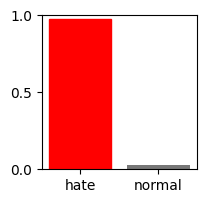

that's funny, I always pay them and I've never been to lunch


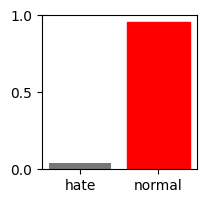

The thing is , your debt to the bank is an asset for them to leverage more money from the treasury or central bank.


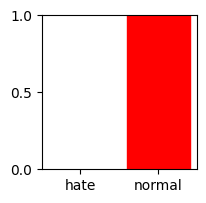

FUCKING NIGGER GO BACK TO AFRICA


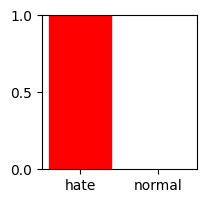

In [ ]:
inputs = [
    "Wish you cut your veins. Don't shout out you have mental problem",
    "that's funny, I always pay them and I've never been to lunch",
    "The thing is , your debt to the bank is an asset for them to leverage more money from the treasury or central bank.",
    "FUCKING NIGGER GO BACK TO AFRICA"
]

examples = tf.constant(inputs)

predictions = export_model.predict(examples)

def plot_value_array(percent):
  thisplot = plt.bar(range(2), [percent, 1.0 - percent], color="#777777")
  plt.xticks(range(2), ['hate', 'normal'])
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])
  predicted_label = 0 if percent >= 0.5 else 1
  thisplot[predicted_label].set_color('red')

for i in range(len(inputs)):
  plt.figure(figsize=(2, 2))
  print(inputs[i])
  plot_value_array(predictions[i][0])
  plt.show()

Lastly, the trained model is saved and ready for deployment.

In [ ]:
export_model.save('drive/MyDrive/Models/binary-NN-model.keras')